In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This is the notebook containing the data analysis and classification task for Precog. The task is to gain some insight from the dataset and then formulate a classification problem on the basis of it. 

The dataset consists of indian court cases. The classification task decided is to classify the court cases based on their disposition. There were a number of labels denoting the disposition status. The task selected was to label the case as having reached a conclusion in the specific court (finalized) containing disposition status 'closed', 'decided', 'disposed', or as not finalized, containing the rest of the labels. 

Due to the size of the dataset, the dataset used is for the 2015 cases. For the analysis, the data is analysed for the effect the gender of the judge, the state, and whether the case is deemed as a criminal case or not has on the case disposition. For classification, the methods used are logistic regression, KNN, Decision Trees and Random Forest

References
The notebook has been constructed on kaggle with the court-cases dataset already uploaded. Chatgpt has been used sparingly for creating graphs and looking up basic syntax. 

In [3]:
'''
Importing the libraries
'''

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
'''
Reading the csv files for merging and getting the gender of the judge
'''
judge_case_key = pd.read_csv('/kaggle/input/court-cases/keys/keys/judge_case_merge_key.csv',usecols=['ddl_case_id','ddl_decision_judge_id'])
judges_data = pd.read_csv('/kaggle/input/court-cases/judges_clean/judges_clean.csv', usecols=['ddl_judge_id','female_judge'])

In [8]:
judges_data.shape

(98478, 2)

In [6]:
'''
Reading the acts_sections file for procuring the information whether the case was deemed as
a criminal case or not. There was an effort to include the information for bailable cases but
the data was not present for a vast majority of cases
'''

dtypes_dict = {
    'ddl_case_id': str,
    'criminal': np.bytes_,
}
acts = pd.read_csv('/kaggle/input/court-cases/acts_sections/acts_sections.csv', usecols=['ddl_case_id','criminal'],  dtype=dtypes_dict)
acts.shape

(76811357, 2)

In [7]:
'''
Extracting the relevant columns from the cases dataset and merging to get the judge ID
'''

columns = ['ddl_case_id','year','state_code','disp_name','type_name','purpose_name', 'judge_position']
file_path = '/kaggle/input/court-cases/cases/cases/cases_2015.csv'
df = pd.read_csv(file_path,usecols=columns)
df = pd.merge(df, judge_case_key, on='ddl_case_id', how = 'inner')
df = pd.merge(df, judges_data, left_on='ddl_decision_judge_id', right_on='ddl_judge_id', how='inner')
df.head()

,ddl_case_id,year,state_code,judge_position,type_name,purpose_name,disp_name,ddl_decision_judge_id,ddl_judge_id,female_judge
0,01-01-01-201908000022015,2015,1,chief judicial magistrate,1978.0,5446.0,30,156.0,156,1 female
1,01-01-01-201908000712015,2015,1,chief judicial magistrate,1978.0,3229.0,51,156.0,156,1 female
2,01-01-01-201908000752015,2015,1,chief judicial magistrate,1978.0,5446.0,30,156.0,156,1 female
3,01-01-01-201908001072015,2015,1,chief judicial magistrate,1978.0,922.0,4,156.0,156,1 female
4,01-01-01-201908001542015,2015,1,chief judicial magistrate,1978.0,3229.0,15,156.0,156,1 female


In [9]:
df['female_judge'].value_counts()

0 nonfemale      1255924
1 female          443758
-9998 unclear      52372
Name: female_judge, dtype: int64

In [10]:
'''
Processing to remove cases in which the gender is unclear. After this operation, we are 
left with 1699682 cases. 
'''
df = df[df['female_judge'] != '-9998 unclear']
df.shape

(1699682, 10)

In [11]:
'''
Reading the following key files to get the purpose name, type name, disposition name and the 
state name. The key files will be used to assign actual names for better data analysis and will
be used after merging them with the main dataset
'''

state_code = pd.read_csv('/kaggle/input/court-cases/keys/keys/cases_state_key.csv', usecols=['year','state_code','state_name'])
purpose = pd.read_csv('/kaggle/input/court-cases/keys/keys/purpose_name_key.csv', usecols=['year','purpose_name','purpose_name_s'])
type_name = pd.read_csv('/kaggle/input/court-cases/keys/keys/type_name_key.csv', usecols=['year','type_name','type_name_s'])
disp_name = pd.read_csv('/kaggle/input/court-cases/keys/keys/disp_name_key.csv', usecols=['year','disp_name','disp_name_s'])

In [12]:
'''
The data is merged to get the disposition name and purpose name. The rows for the nan values
are discarded and we are left with 1282707 cases
'''

df = pd.merge(df, disp_name, on=['disp_name','year'], how='inner')
df = df[df['disp_name_s'] != 'disposition var missing']
df = pd.merge(df, acts, on='ddl_case_id', how='inner')
df.dropna(subset=['purpose_name'], inplace=True)
df.shape

(1282707, 12)

In [13]:
'''
Merging to get state name, type name and purpose name and removing any values not present 
in the keys
'''

df = pd.merge(df, state_code, on=['year','state_code'], how='inner')
df = df.drop(columns=['state_code'])
df = pd.merge(df, type_name, on=['year','type_name'], how='inner')
df = df.drop(columns=['type_name'])
df = pd.merge(df, purpose, on=['year','purpose_name'], how='inner')
df = df.drop(columns=['purpose_name'])
df.head()

,ddl_case_id,year,judge_position,disp_name,ddl_decision_judge_id,ddl_judge_id,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,01-01-01-201908000022015,2015,chief judicial magistrate,30,156.0,156,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
1,01-01-01-201908000752015,2015,chief judicial magistrate,30,156.0,156,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
2,01-01-01-201908000932015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
3,01-01-01-201908003362015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
4,01-01-01-201908003942015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement


In [15]:
'''
Dropping cases where the purpose name is not found
'''
df.dropna(subset=['purpose_name_s'], inplace=True)
df.head()

,ddl_case_id,year,judge_position,disp_name,ddl_decision_judge_id,ddl_judge_id,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,01-01-01-201908000022015,2015,chief judicial magistrate,30,156.0,156,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
1,01-01-01-201908000752015,2015,chief judicial magistrate,30,156.0,156,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
2,01-01-01-201908000932015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
3,01-01-01-201908003362015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
4,01-01-01-201908003942015,2015,chief judicial magistrate,30,159.0,159,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement


In [16]:
'''
Removing redundant columns
'''
df = df.drop(columns = ['disp_name','ddl_judge_id','year', 'ddl_case_id'])
df.head()

,judge_position,ddl_decision_judge_id,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,chief judicial magistrate,156.0,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
1,chief judicial magistrate,156.0,1 female,judgement,1,Maharashtra,cri.m.a.,judgement
2,chief judicial magistrate,159.0,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
3,chief judicial magistrate,159.0,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement
4,chief judicial magistrate,159.0,0 nonfemale,judgement,1,Maharashtra,cri.m.a.,judgement


In [17]:
'''
Analysis of the disposition values
'''
df['disp_name_s'].value_counts()

allowed                   210265
disposed                  150414
acquitted                 140920
dismissed                 124766
transferred                91173
reject                     69832
judgement                  58974
fine                       54055
convicted                  46481
disposed-otherwise         43257
referred to lok adalat     38829
decided                    38101
other                      32814
compromise                 26954
withdrawn                  25774
plead guilty               19050
committed                  16707
closed                     15798
procedural                 12240
otherwise                   9651
disposal in lok adalat      6535
untrace                     6420
probation                   6032
abated                      5243
not press                   4974
confession                  4911
settled                     2811
plea bargaining             2152
absconded                   1979
quash                       1978
compounded

In [18]:
'''
Assigning closed, decided, disposed as finalised and the rest as not
'''
df['disp_name_s'] = df['disp_name_s'].apply(lambda x: 'finalized' if x in ['closed', 'decided', 'disposed'] else 'not finalized')

In [19]:
'''
Checking the distribution
'''
df['disp_name_s'].value_counts()

not finalized    1078043
finalized         204313
Name: disp_name_s, dtype: int64

In [20]:
'''
Method to plot bar graph
'''

import matplotlib.pyplot as plt

def plot_bar_graph(x_axis, finalized_count_list, non_finalized_count_list, x_axis_label, plot_title):
    x_positions = range(len(x_axis))
    bar_width = 0.1
    plt.bar(x_positions, finalized_count_list, width=bar_width, label='Finalized cases')
    plt.bar([pos + bar_width for pos in x_positions], non_finalized_count_list, width=bar_width, label='Non finalized cases')
    plt.xlabel(x_axis_label)
    plt.ylabel('Count')
    plt.title(plot_title)
    plt.xticks([pos + bar_width / 2 for pos in x_positions], x_axis)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
'''
Method to display table
'''

def display_table(set1_labels, set2_labels, values):
    data = {
        'Set 1': [set1_labels[0], set1_labels[0], set1_labels[1], set1_labels[1]],
        'Set 2': [set2_labels[0], set2_labels[1], set2_labels[0], set2_labels[1]],
        'Count': values
    }
    combination_table = pd.DataFrame(data)
    combination_table = combination_table.pivot(index='Set 1', columns='Set 2', values='Count')
    combination_table = combination_table.fillna(0)
    combination_table = combination_table.rename_axis(index=None, columns=None)
    print(combination_table)

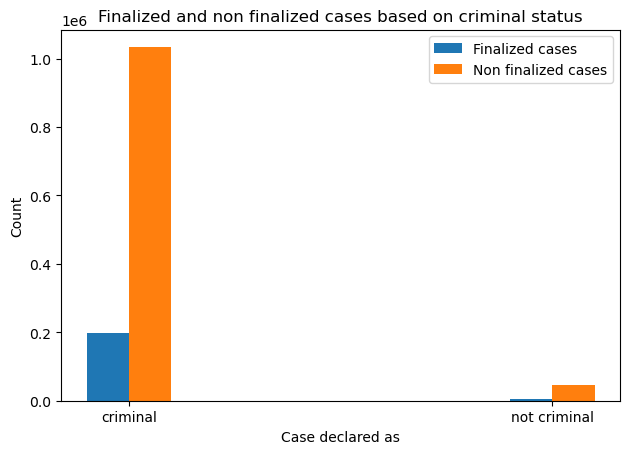

In [21]:
x_axis = ['criminal', 'not criminal']
finalized_count_list = [((df['criminal'] == '1') & (df['disp_name_s'] == 'finalized')).sum(), ((df['criminal'] == '0') & (df['disp_name_s'] == 'finalized')).sum()]
non_finalized_count_list = [((df['criminal'] == '1') & (df['disp_name_s'] == 'not finalized')).sum(), ((df['criminal'] == '0') & (df['disp_name_s'] == 'not finalized')).sum()]
x_axis_label = 'Case declared as' 
plot_title = 'Finalized and non finalized cases based on criminal status'
plot_bar_graph(x_axis, finalized_count_list, non_finalized_count_list, x_axis_label, plot_title)

In [37]:
set1_labels = ['criminal', 'not criminal']
set2_labels = ['finalized', 'not finalized']
values = [finalized_count_list[0]/(non_finalized_count_list[0] + finalized_count_list[0]), non_finalized_count_list[0]/(non_finalized_count_list[0] + finalized_count_list[0]),finalized_count_list[1]/(non_finalized_count_list[1] + finalized_count_list[1]), non_finalized_count_list[1]/(non_finalized_count_list[1] + finalized_count_list[1])]
display_table(set1_labels, set2_labels, values)

'''
Executing above code with yield the distribution of the cases into finalized and non finalized
disposition according to the criminal value. There is a slight chance of more proportion of 
cases being finalized if the cases are criminal in nature
'''

              finalized  not finalized
criminal       0.161568       0.838432
not criminal   0.103704       0.896296


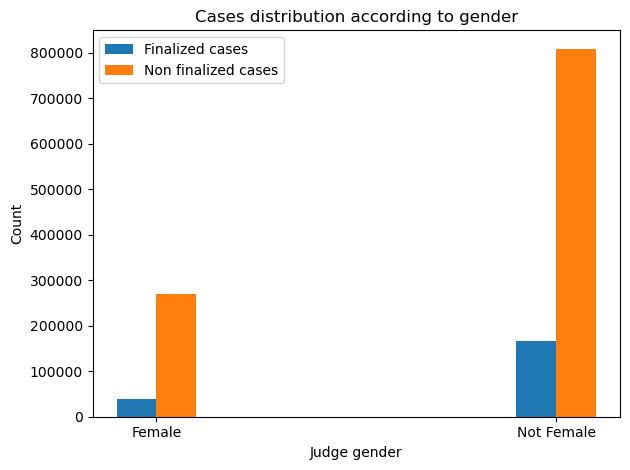

In [39]:
x_axis = ['Female', 'Not Female']
finalized_count_list = [((df['female_judge'] == '1 female') & (df['disp_name_s'] == 'finalized')).sum(), ((df['female_judge'] == '0 nonfemale') & (df['disp_name_s'] == 'finalized')).sum()]
non_finalized_count_list = [((df['female_judge'] == '1 female') & (df['disp_name_s'] == 'not finalized')).sum(), ((df['female_judge'] == '0 nonfemale') & (df['disp_name_s'] == 'not finalized')).sum()]
x_axis_label = 'Judge gender' 
plot_title = 'Cases distribution according to gender'
plot_bar_graph(x_axis, finalized_count_list, non_finalized_count_list, x_axis_label, plot_title)

In [40]:
set1_labels = ['Female', 'Not Female']
set2_labels = ['finalized', 'not finalized']
values = [finalized_count_list[0]/(non_finalized_count_list[0] + finalized_count_list[0]), non_finalized_count_list[0]/(non_finalized_count_list[0] + finalized_count_list[0]),finalized_count_list[1]/(non_finalized_count_list[1] + finalized_count_list[1]), non_finalized_count_list[1]/(non_finalized_count_list[1] + finalized_count_list[1])]
display_table(set1_labels, set2_labels, values)

'''
Executing above code with yield the distribution of the cases into finalized and non finalized
disposition according to the gender of the judge. There is a slight chance of more proportion 
of  cases being finalized if the judge is not female, however the number of female judges is 
less, so this fact should be taken into account while making any observations
'''

            finalized  not finalized
Female       0.126357       0.873643
Not Female   0.169746       0.830254


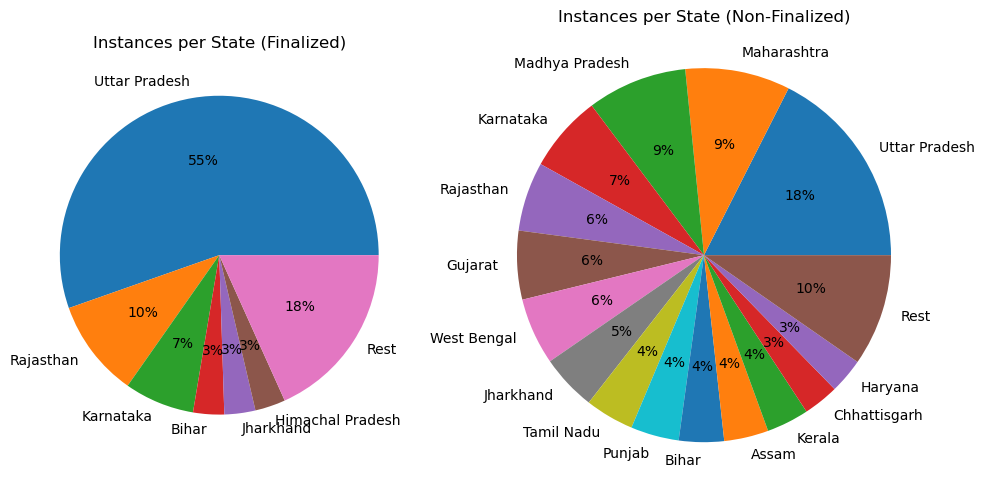

In [41]:
'''
Code for plotting the pie chart of the disposition status of cases according to state. The 
vast majority of cases in the finalized category come from Uttar Pradesh. In non-finalized 
cases the distribution is more equitable. 
'''

threshold = 0.03

finalized_df = df[df['disp_name_s'] == 'finalized']
non_finalized_df = df[df['disp_name_s'] == 'not finalized']

finalized_state_counts = finalized_df['state_name'].value_counts()
non_finalized_state_counts = non_finalized_df['state_name'].value_counts()

finalized_total_instances = len(finalized_df)
finalized_low_proportion_states = finalized_state_counts[finalized_state_counts / finalized_total_instances < threshold].index.tolist()
finalized_rest_count = finalized_state_counts[finalized_state_counts / finalized_total_instances < threshold].sum()
finalized_state_counts = finalized_state_counts.drop(finalized_low_proportion_states)
finalized_state_counts['Rest'] = finalized_rest_count

non_finalized_total_instances = len(non_finalized_df)
non_finalized_low_proportion_states = non_finalized_state_counts[non_finalized_state_counts / non_finalized_total_instances < threshold].index.tolist()
non_finalized_rest_count = non_finalized_state_counts[non_finalized_state_counts / non_finalized_total_instances < threshold].sum()
non_finalized_state_counts = non_finalized_state_counts.drop(non_finalized_low_proportion_states)
non_finalized_state_counts['Rest'] = non_finalized_rest_count

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(finalized_state_counts, labels=finalized_state_counts.index, autopct='%1.0f%%')
plt.title('Instances per State (Finalized)')

plt.subplot(1, 2, 2)
plt.pie(non_finalized_state_counts, labels=non_finalized_state_counts.index, autopct='%1.0f%%')
plt.title('Instances per State (Non-Finalized)')

plt.axis('equal')
plt.tight_layout()
plt.show()

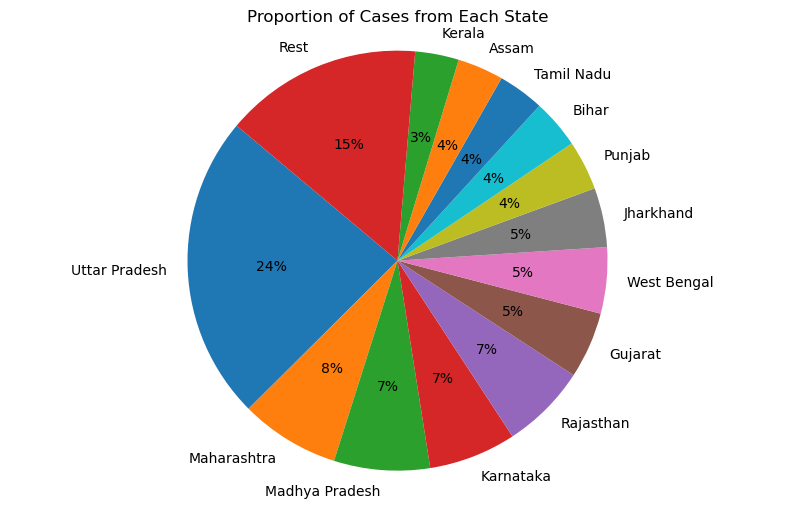

In [42]:
'''
Code for plotting the pie chart of the cases according to state for more context. 
While Uttar Pradesh does account for 1/4 of the cases in the dataset, the number
of finalized cases is still noteable
'''

state_counts = df['state_name'].value_counts()

threshold = 0.03  

total_cases = state_counts.sum()

mask = (state_counts / total_cases) < threshold

rest_cases = state_counts[mask].sum()
state_counts = state_counts[~mask]
state_counts['Rest'] = rest_cases

plt.figure(figsize=(10, 6))  
plt.pie(state_counts.values, labels=state_counts.index, autopct='%1.0f%%', startangle=140)

plt.title('Proportion of Cases from Each State')

plt.axis('equal')  
plt.show()

In [43]:
'''
Checking if nan values exist
'''
df.isna().sum()

judge_position           0
ddl_decision_judge_id    0
female_judge             0
disp_name_s              0
criminal                 0
state_name               0
type_name_s              9
purpose_name_s           0
dtype: int64

In [45]:
'''
Removing redundant columns and nan values from type name
'''

df.dropna(subset=['type_name_s'], inplace=True)
df['disp_name_s'] = (df['disp_name_s'] == 'finalized').astype(int)
df.head()

,judge_position,ddl_decision_judge_id,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,chief judicial magistrate,156.0,1 female,0,1,Maharashtra,cri.m.a.,judgement
1,chief judicial magistrate,156.0,1 female,0,1,Maharashtra,cri.m.a.,judgement
2,chief judicial magistrate,159.0,0 nonfemale,0,1,Maharashtra,cri.m.a.,judgement
3,chief judicial magistrate,159.0,0 nonfemale,0,1,Maharashtra,cri.m.a.,judgement
4,chief judicial magistrate,159.0,0 nonfemale,0,1,Maharashtra,cri.m.a.,judgement


In [46]:
'''
Labelling gender of the judge 
'''
df['female_judge'] = (df['female_judge'] == '1 female').astype(int)
df.head()

,judge_position,ddl_decision_judge_id,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,chief judicial magistrate,156.0,1,0,1,Maharashtra,cri.m.a.,judgement
1,chief judicial magistrate,156.0,1,0,1,Maharashtra,cri.m.a.,judgement
2,chief judicial magistrate,159.0,0,0,1,Maharashtra,cri.m.a.,judgement
3,chief judicial magistrate,159.0,0,0,1,Maharashtra,cri.m.a.,judgement
4,chief judicial magistrate,159.0,0,0,1,Maharashtra,cri.m.a.,judgement


In [47]:
'''
removing redundant column
'''
df = df.drop(columns=['ddl_decision_judge_id'])
df.head()

,judge_position,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,chief judicial magistrate,1,0,1,Maharashtra,cri.m.a.,judgement
1,chief judicial magistrate,1,0,1,Maharashtra,cri.m.a.,judgement
2,chief judicial magistrate,0,0,1,Maharashtra,cri.m.a.,judgement
3,chief judicial magistrate,0,0,1,Maharashtra,cri.m.a.,judgement
4,chief judicial magistrate,0,0,1,Maharashtra,cri.m.a.,judgement


In [48]:
'''
Encoding the categorical columns
'''
columns_to_encode = ['judge_position','state_name','type_name_s','purpose_name_s']
label_encoder = LabelEncoder()
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,judge_position,female_judge,disp_name_s,criminal,state_name,type_name_s,purpose_name_s
0,42,1,0,1,15,585,1591
1,42,1,0,1,15,585,1591
2,42,0,0,1,15,585,1591
3,42,0,0,1,15,585,1591
4,42,0,0,1,15,585,1591


In [96]:
df = pd.read_csv('/kaggle/input/indian-court-cases/labelled_data-2.csv')

In [97]:
df['disp_name_s'].value_counts()

0    1078039
1     204308
Name: disp_name_s, dtype: int64

In [98]:
'''
Splitting into train and test sets with a 75/25 split
'''
y = df['disp_name_s']
X = df.drop(columns=['disp_name_s'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [74]:
X_train

,judge_position,female_judge,criminal,state_name,type_name_s,purpose_name_s
446387,49,0,1,12,200,1452
953163,52,0,1,28,11,548
217858,46,1,1,7,255,977
86512,42,0,1,15,585,1810
778866,48,0,1,26,414,170
...,...,...,...,...,...,...
110268,52,0,1,14,145,1810
259178,28,0,1,21,1620,977
131932,44,0,1,12,784,1810
671155,57,1,1,13,2014,2407


In [99]:
'''
Function for plotting the metrics. Computes the ROC curve and publishes the classification 
report along with the accuracy
'''
def plot_metrics(y_test,y_pred,y_pred_prob):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(y_test)))  # Number of classes
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

    plt.show()


    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [102]:
'''
Modelling logistic regression with gridsearchcv for hyperparameter tuning
'''

model = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.0001, 0.001, 1],
    'max_iter': [500, 750, 1000]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1] 

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91    269119
           1       0.02      0.00      0.00     51468

    accuracy                           0.84    320587
   macro avg       0.43      0.50      0.46    320587
weighted avg       0.71      0.84      0.77    320587



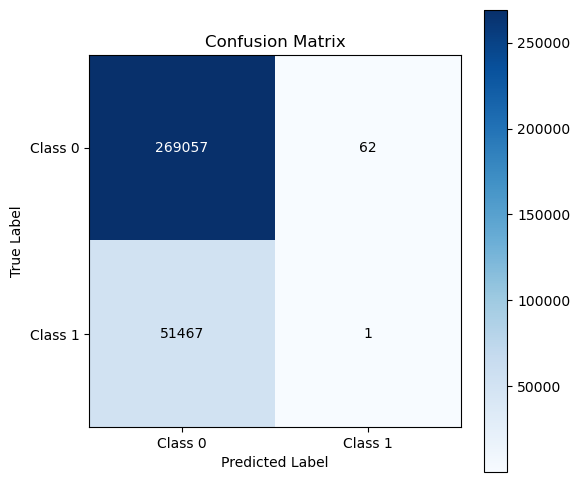

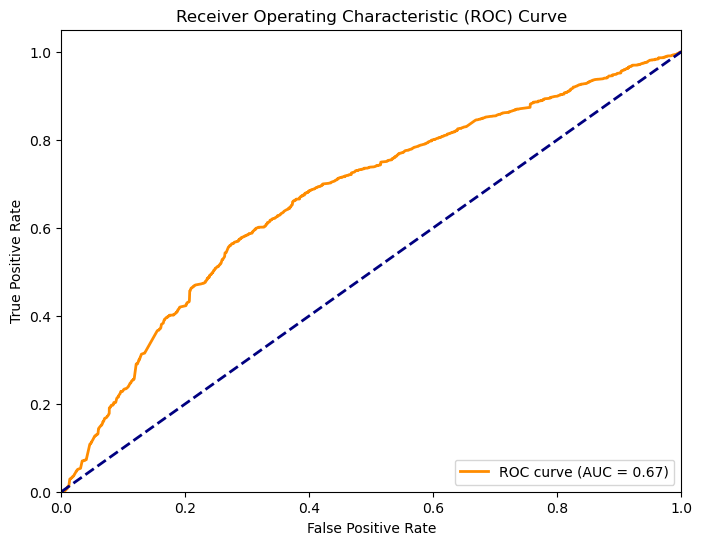

In [103]:
plot_metrics(y_test,y_pred,y_pred_prob)

In [104]:
'''
Modelling decision tree
'''
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
y_pred_prob = dt_classifier.predict_proba(X_test)[:, 1] 

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    269119
           1       0.70      0.46      0.56     51468

    accuracy                           0.88    320587
   macro avg       0.80      0.71      0.74    320587
weighted avg       0.87      0.88      0.87    320587



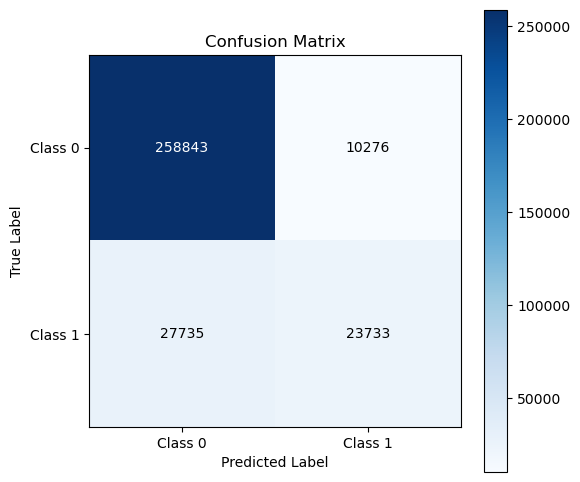

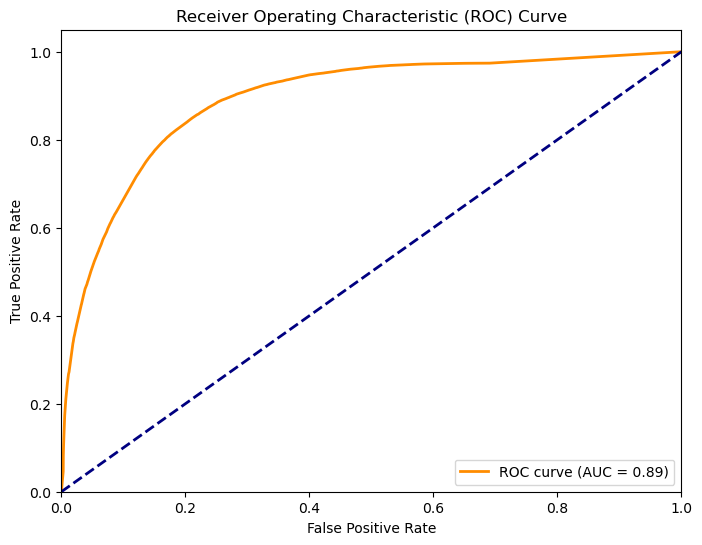

In [105]:
plot_metrics(y_test,y_pred,y_pred_prob)

In [106]:
'''
Modelling k nearest neighbours with k being 5
'''
k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
y_pred_prob = knn_classifier.predict_proba(X_test)[:, 1] 

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    269119
           1       0.58      0.53      0.55     51468

    accuracy                           0.86    320587
   macro avg       0.75      0.73      0.74    320587
weighted avg       0.86      0.86      0.86    320587



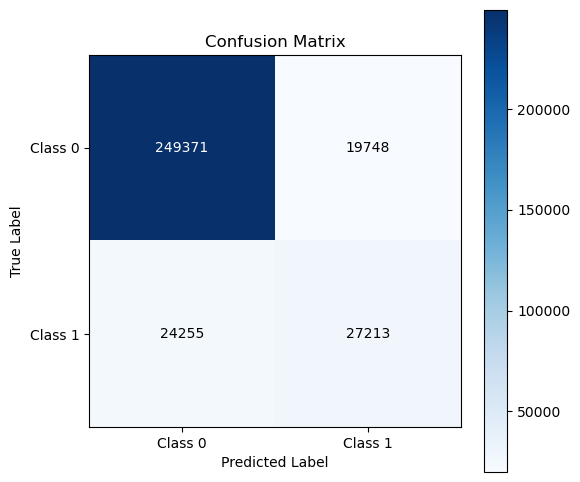

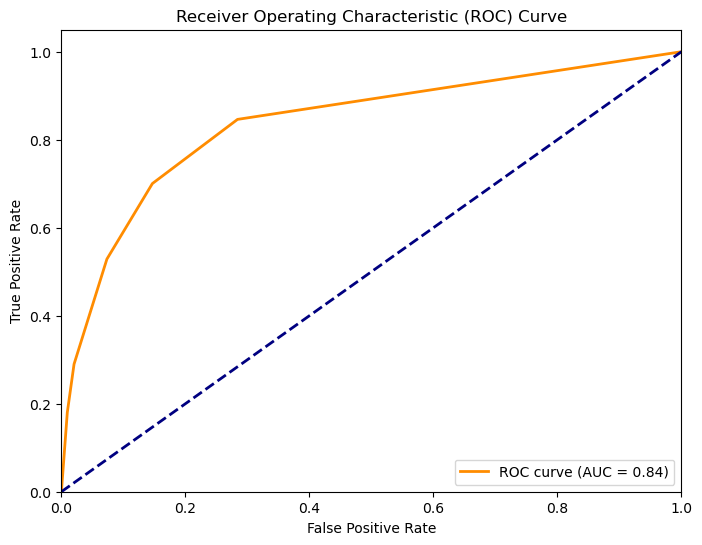

In [107]:
plot_metrics(y_test,y_pred,y_pred_prob)

In [110]:
'''
Modelling random forest
'''

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1] 

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93    269119
           1       0.70      0.46      0.56     51468

    accuracy                           0.88    320587
   macro avg       0.80      0.71      0.74    320587
weighted avg       0.87      0.88      0.87    320587



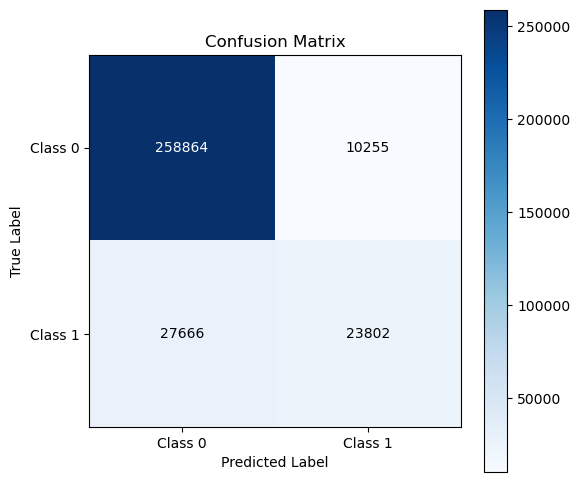

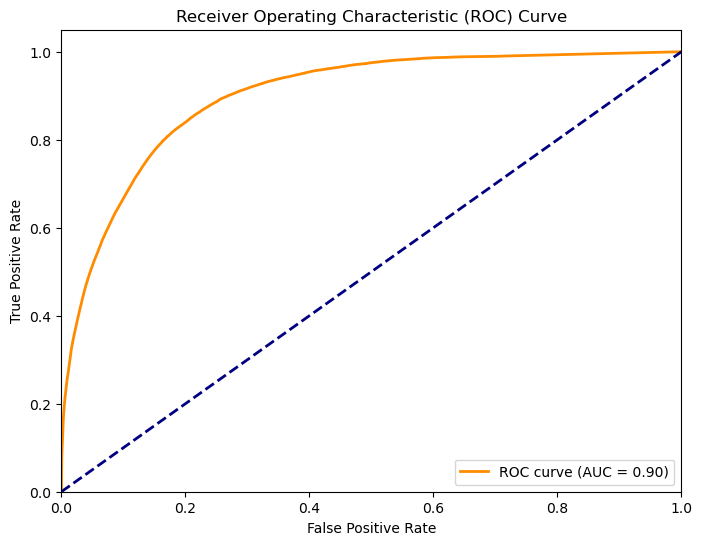

In [111]:
plot_metrics(y_test,y_pred,y_pred_prob)